## Imports

In [2]:
using ChaosTools
using DifferentialEquations
using Plots
using LinearAlgebra
using Plots.PlotMeasures
using LaTeXStrings
using JLD2
using NPZ
using Distributions
using DynamicalSystems

In [3]:
include("Network.jl")
include("HomogeneousSystem.jl")

Main.HomogeneousSystem

### Parameter Structure

In [6]:
# Define a parameter struct that contains the scalar parameters and the matrix
struct Params
    scalar_params::Vector{Float64}  # Vector of scalar parameters (e.g., p[1], p[2], ...)
    matrix_params::Matrix{Float64}  # The normalized connectivity matrix
end

## Integrate homogeneous system to find point on periodic orbit

In [20]:
# Initial conditions (size should match the system, here we have a 2D system)
u0 = zeros(6)

# Time span
# Initial time
t0 = 0
# Final time
tf = 2000
tspan = (t0, tf)

# Define the parameters as a dictionary
p = [8,8,1,5,-5,-5,1,1,5,13,5,13,0,15,9];

In [21]:
# Define the problem using the system and parameters
prob = ODEProblem(HomogeneousSystem.HomogeneousSystem!, u0, tspan, p)
# Solve the ODE problem using RK45
sol = solve(prob,reltol = 1e-6,abstol = 1e-6,saveat=0.001);

In [ ]:
Nvariables = 6
Npop = 90

# Set initial condition on network
u0 = zeros(Npop*Nvariables)
u0[1:Npop] = fill(fin[1],Npop)
u0[1+Npop:2*Npop] = fill(fin[2],Npop)
u0[1+2*Npop:3*Npop] = fill(fin[3],Npop)
u0[1+3*Npop:4*Npop] = fill(fin[4],Npop)
u0[1+4*Npop:5*Npop] = fill(fin[5],Npop)
u0[1+5*Npop:end] = fill(fin[6],Npop)
u0

540-element Vector{Float64}:
 0.1254633867562253
 0.1254633867562253
 0.1254633867562253
 0.1254633867562253
 0.1254633867562253
 0.1254633867562253
 0.1254633867562253
 0.1254633867562253
 0.1254633867562253
 0.1254633867562253
 ⋮
 0.13590507413573347
 0.13590507413573347
 0.13590507413573347
 0.13590507413573347
 0.13590507413573347
 0.13590507413573347
 0.13590507413573347
 0.13590507413573347
 0.13590507413573347

In [ ]:
Nvariables = 6
Npop = 90

# Define the normal distribution (mean=0, standard deviation=1)
dist = Normal(0, 0.01)

# Generate random vector
random_vector = rand(dist, Npop*Nvariables)

# Initial conditions 
u0 .+= random_vector

# Time span
# Initial time
t0 = 0
# Final time
tf = 1000
tspan = (t0, tf)

# Define the parameters as a dictionary
scalar_params = [8,8,1,5,-5,-5,1,1,5,13,5,13,0,15,9];

# Load the .npz file containing the connectivity matrix into a dictionary-like structure
data = load("NormalizedMatrix.npz")
W = data["normalized_matrix"]

# Create the Params struct
p = Params(scalar_params, W)

Params([8.0, 8.0, 1.0, 5.0, -5.0, -5.0, 1.0, 1.0, 5.0, 13.0, 5.0, 13.0, 0.0, 15.0, 9.0], [0.0 0.07150787333365484 … 0.029938437471751827 0.0457088009950454; 0.040356800998807764 0.0 … 0.0844727476667492 0.0069661426632191365; … ; 0.011030461432017217 0.05514665431799544 … 0.0 0.055906608276557586; 0.029621282116852266 0.007999004709306763 … 0.09833390557208707 0.0])

## Integrating with Differential Equations solve

In [26]:
# Define the problem using the system and parameters
prob = ODEProblem(Network.Network!, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
Non-trivial mass matrix: false
timespan: (0, 1000)
u0: 540-element Vector{Float64}:
 0.12082795840408017
 0.10695713699209014
 0.1259886615267128
 0.13530872243727007
 0.12445340442964613
 0.10813342537719213
 0.1296992262589665
 0.13557020491245284
 0.11931850615229962
 0.12986924880321862
 ⋮
 0.15203986617048984
 0.14128034559227723
 0.1377490675520354
 0.13038898098420276
 0.14157089134656267
 0.15297095043023207
 0.13520339992780347
 0.13540344448287406
 0.12232699444339239

In [ ]:
# Solve the ODE problem using RK45

#@profview sol = solve(prob,reltol = 1e-6,abstol = 1e-6,saveat=0.001);
sol = solve(prob,reltol = 1e-6,abstol = 1e-6,RK4(); dt=0.01, adaptive=false);

In [28]:
size(sol)

(540, 100002)

In [ ]:
# Unpack state variables
idx_ve = 1
idx_se = 2
idx_ri = 3
idx_vi = 4
idx_si = 5
@inbounds r_e_vector = @view sol[1:90,:]
@inbounds v_e_vector = @view sol[90*idx_ve+1:90*idx_se,:]
@inbounds s_e_vector = @view sol[90*idx_se+1:90*idx_ri,:]
@inbounds r_i_vector = @view sol[90*idx_ri+1:90*idx_vi,:]
@inbounds v_i_vector = @view sol[90*idx_vi+1:90*idx_si,:]
@inbounds s_i_vector = @view sol[90*idx_si+1:90*6,:]

90×100002 view(::ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, Nothing, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Params, ODEFunction{true, SciMLBase.AutoSpecialize, FunctionWrappersWrappers.FunctionWrappersWrapper{Tuple{FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{Float64}, Vector{Float64}, Params, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Params, Float64}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}, Vector{Float64}, Params, ForwardDiff.Dual{ForwardDiff.Tag{DiffEqBase.OrdinaryDiffEqTag, Float64}, Float64, 1}}}, FunctionWrappers.FunctionWrapper{Nothing, Tuple{Vector{ForwardDiff.Dual{ForwardD

In [31]:
size(v_e_vector)

(90, 100002)

## Plot results

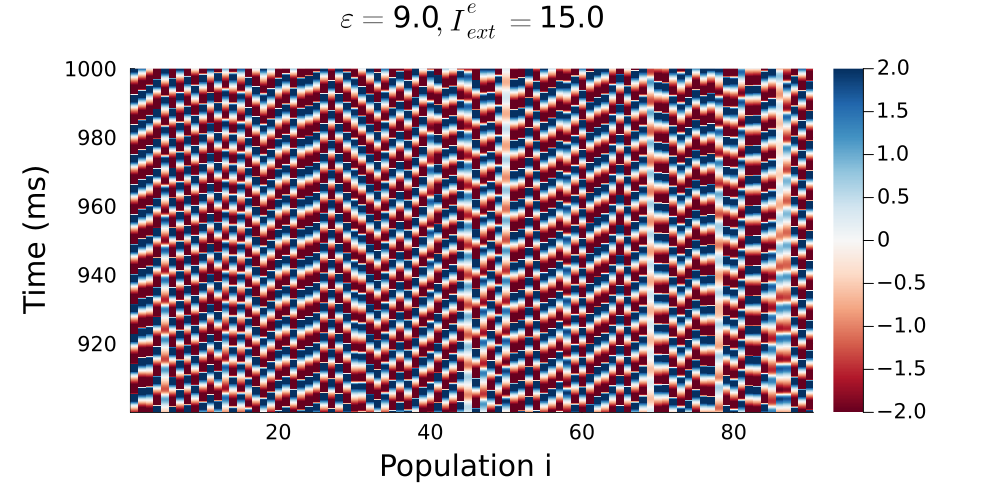

In [ ]:
# Set the backend to GR
gr()  
vmin = -2
vmax = 2
idx_ms = 100
step = 0.01
# Loop over each column and plot it in a different color
plt= heatmap()
heatmap(1:Npop,sol.t[end-Int(floor(idx_ms/step)):end],transpose(v_e_vector[:,end-Int(floor(idx_ms/step)):end]), color=:RdBu,clims=(vmin, vmax),left_margin=2cm,right_margin=2cm,colorbar = true, colorbar_position = :right)

# Set labels
xlabel!("Population i ",xguidefontsize=20,bottom_margin = 10mm)
ylabel!("Time (ms)",yguidefontsize=20,left_margin = 10mm)
plot!(xtickfont=14,ytickfont=14)
# Set the legend to have two columns
#plot!(legend=:outertop, legendfontsize=5,legendcolumns=3)
# Set the figure size (make it wider)
plot!(title=L"\epsilon = " * string(p.scalar_params[15]) * L", I_{ext}^e = " * string(p.scalar_params[14]),titlefont = font(20),top_margin = 10mm)
#savefig("CheckSimsNetwork/eps=" * string(p.scalar_params[15]) * "_Iext_e=" * string(p.scalar_params[14]) * ".png")
plot!(size=(1000, 500)) 
